In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os
from scipy.cluster.vq import vq, kmeans, whiten

nlp = spacy.load("en_core_web_md")

In [72]:
# (1)
# Load the data
data_df = pd.read_csv('Travel_Chalenge.csv', sep=";")

# Remove rating without a value
# Convert the column to numeric, coercing errors to NaN
data_df["Overall_Rating"] = pd.to_numeric(data_df["Overall_Rating"],
                                          errors='coerce')

# Drop rows with NaN values in the specified column
data_df = data_df.dropna(subset=["Overall_Rating"])



In [73]:
# (2)
columns_to_be_analyzed = ["Review", "Review_Title"]

# Preprocess the data if the preprocessed 'cache' does not exist
pre_pickled_file = "preprocessed_data.pkl"
if not os.path.exists(pre_pickled_file) or os.path.getsize(
        pre_pickled_file) == 0:
    for column in columns_to_be_analyzed:
        # Convert to lowercase
        data_df[column] = data_df[column].apply(lambda x: x.lower()
                                                if isinstance(x, str) else x)
        # Remove non-words and punctuation
        data_df[column].replace(to_replace=r'[^\w\s]',
                                value='',
                                regex=True,
                                inplace=True)

        # Tokenize and remove stopwords

        data_df[column + "_doc"] = data_df[column].apply(lambda x: nlp(x))
        data_df[column + "_doc_tokens"] = data_df[column + "_doc"].apply(
            lambda doc: " ".join(
                [token.text for token in doc if not token.is_stop]))
        # Apply lemmatization
        data_df[column] = data_df[column + "_doc"].apply(
            lambda doc: [token.lemma_ for token in doc])
    data_df.to_pickle(pre_pickled_file)
else:
    data_df = pd.read_pickle(pre_pickled_file)

Text(0.5, 1.0, 'Distribution of Ratings')

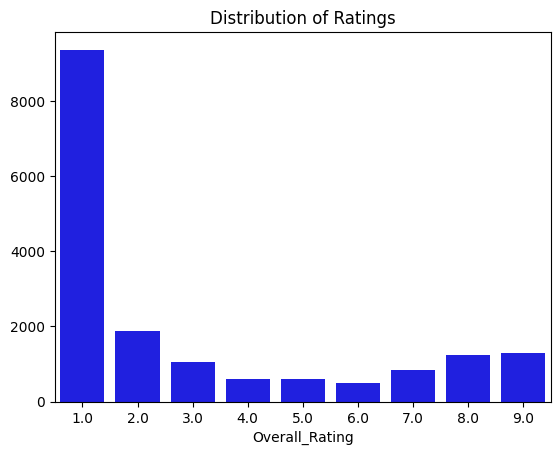

In [74]:
# (3.a.1)
# Plot the distribution of the ratings
rating_counts = data_df["Overall_Rating"].value_counts().sort_index()
plt.figure()
sns.barplot(x=rating_counts.index, y=rating_counts.values, color="Blue")
plt.title("Distribution of Ratings")

We can se that the *Overall Rating* is in avarage pretty slow. Showing that in general the perception of the public is negative towards flights. 

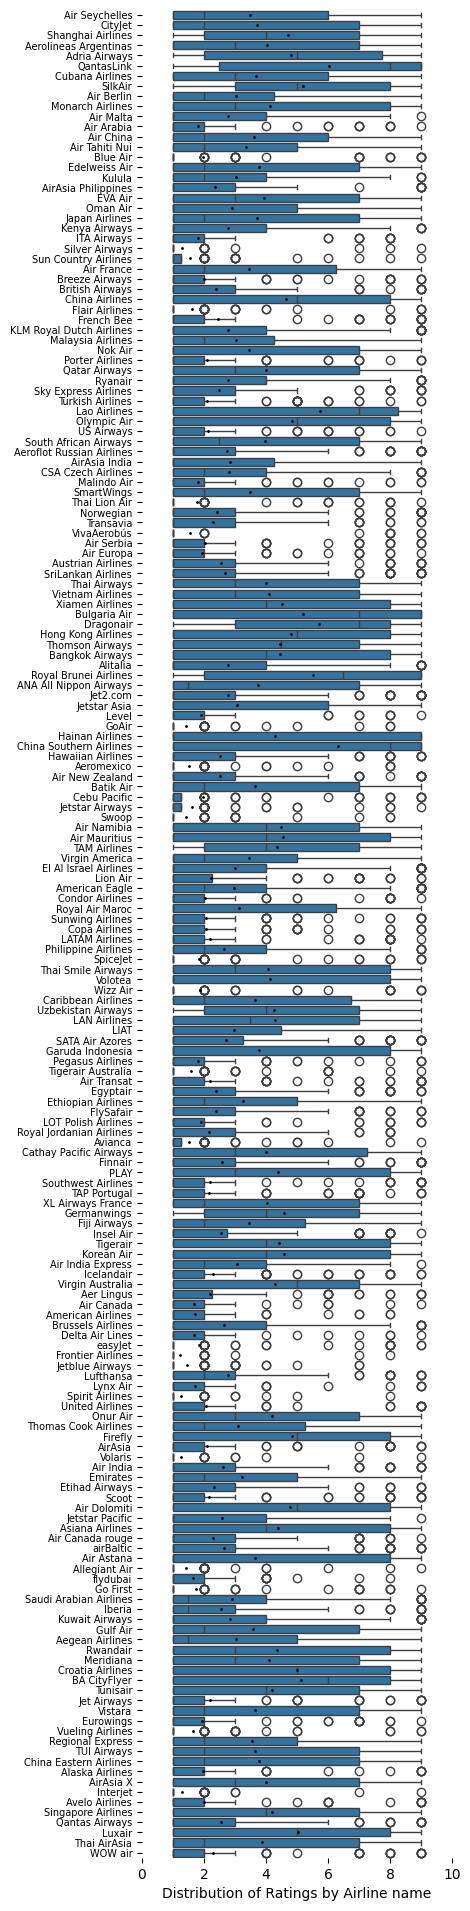

In [130]:
# (3.a.1)
# Removing outliers from the data
# Calculate the z-score of the data
z_scores = (data_df["Overall_Rating"] - data_df["Overall_Rating"].mean()) / \
           data_df["Overall_Rating"].std()
# Remove the outliers
data_df_without_outliers = data_df[np.abs(z_scores) < 3]

# Plot the distribution of the feature overral_rating by the airline
f, ax = plt.subplots(figsize=(4, 24))
sns.boxplot(x="Overall_Rating", y=data_df["Airline Name"], data=data_df_without_outliers, showmeans=True, meanprops={"marker": ".", "markerfacecolor": "black", "markeredgecolor": "black", "markersize":"2"})
plt.setp(ax.get_yticklabels(),
         fontsize=7)
ax.set(xlim=(0, 10), ylabel="",
       xlabel="Distribution of Ratings by Airline name")
sns.despine(left=True, bottom=True)

In [139]:
# Get the airlines with the mean rating largest than 6
airlines_median_rating = data_df.groupby("Airline Name")["Overall_Rating"].median()
airlines_median_rating = airlines_median_rating[airlines_median_rating > 7]

# Get the airlines with the mean rating largest than 6
airlines_mean_rating = data_df.groupby("Airline Name")["Overall_Rating"].mean()
airlines_mean_rating = airlines_mean_rating[airlines_mean_rating > 6]
print("Airlines with median rating larger than 7 and mean larger than 6")
print(airlines_mean_rating.index[0], "and", airlines_mean_rating.index[1])

Airlines with median rating larger than 7 and mean larger than 6
China Southern Airlines and QantasLink


And the trend of negative ratings extends to the airlines, whith only 2 airlines with neutrals reviews (Overall ratings >=4 and <=7) in avarage. And the rest of the airlines have negative reviews in avarage.

In [76]:
# (3.a.2)
# Preparing for the aircraft-rating analysis
# Doing the analysis between overall rating and aircraft
df_without_nan_aircraft = data_df.dropna(subset=["Aircraft"]).copy()

# Remove non-words and punctuation
df_without_nan_aircraft["Aircraft_doc"] = df_without_nan_aircraft[
    "Aircraft"].replace(to_replace=r'[^\w\s]', value=' ', regex=True)

df_without_nan_aircraft["Aircraft_doc"] = df_without_nan_aircraft[
    "Aircraft_doc"].apply(lambda x: x.lower() if isinstance(x, str) else x)

# Tokenize and remove stopwords
df_without_nan_aircraft["Aircraft_doc"] = df_without_nan_aircraft[
    "Aircraft_doc"].apply(lambda x: nlp(x))

df_without_nan_aircraft["Aircraft_vec"] = df_without_nan_aircraft[
    "Aircraft_doc"].apply(lambda x: x.vector)


In [168]:
# Clusterize the aircraft names using kmeans so that we 
# can use the labels as a feature.
# Labeling by analizing the aircraft names end grouping by similar names
# Like Airbus 320 to A320 is the same aircraft but with different names
# A simple regex could not fixes, because there are many different ways
# to write theirs names
whitened_features = whiten(df_without_nan_aircraft["Aircraft_vec"].to_list())
codebook, distortion = kmeans(whitened_features, 20)
labels, test = vq(whitened_features, codebook)
df_without_nan_aircraft[
    "Aircraft_label"] = df_without_nan_aircraft.Aircraft_doc[
        df_without_nan_aircraft.Aircraft_doc.index[labels]].to_list()
df_without_nan_aircraft["Aircraft_label"] = df_without_nan_aircraft[
    "Aircraft_label"].apply(lambda x: x.__repr__().title())

Text(0.5, 1.0, 'Boxplot of Ratings by Aircraft')

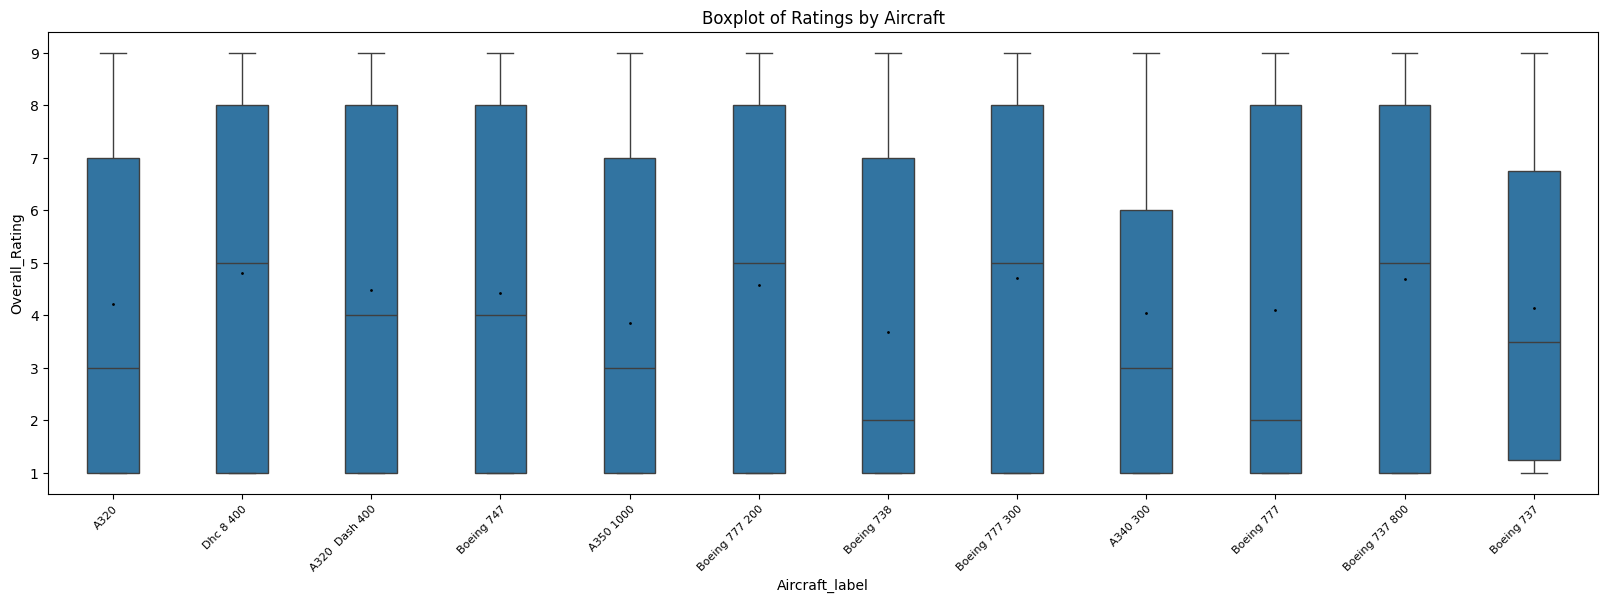

In [156]:
# (3.a.2)
# Plot the boxplot of the ratings by aircraft labels
plt.figure(figsize=(20, 6))
ax = sns.boxplot(x="Aircraft_label",
                 y="Overall_Rating",
                 width=0.4,
                 data=df_without_nan_aircraft, showmeans=True, meanprops={"marker": ".", "markerfacecolor": "black", "markeredgecolor": "black", "markersize":"2"})
plt.setp(ax.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor",
         fontsize=8)
plt.title("Boxplot of Ratings by Aircraft")

Text(0.5, 1.0, 'Word Cloud of Reviews with Rating >= 8')

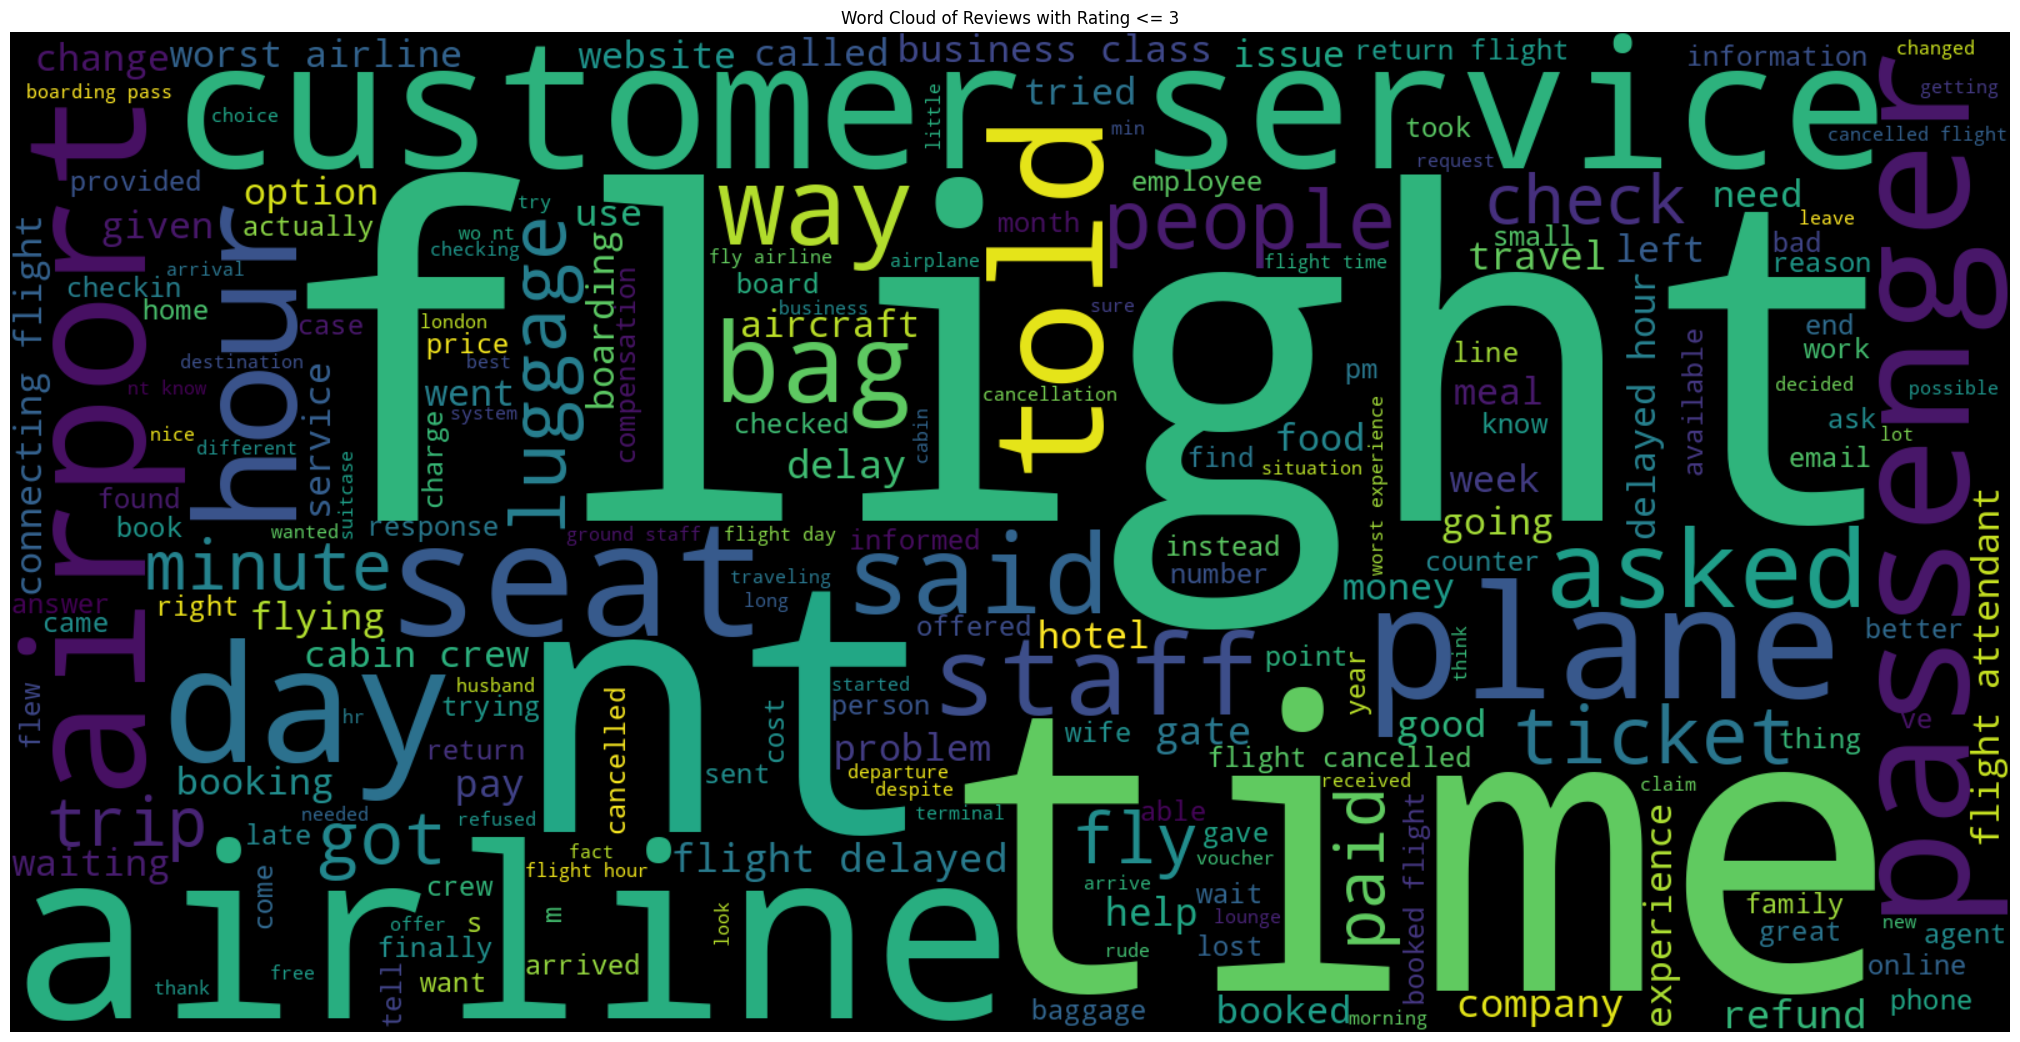

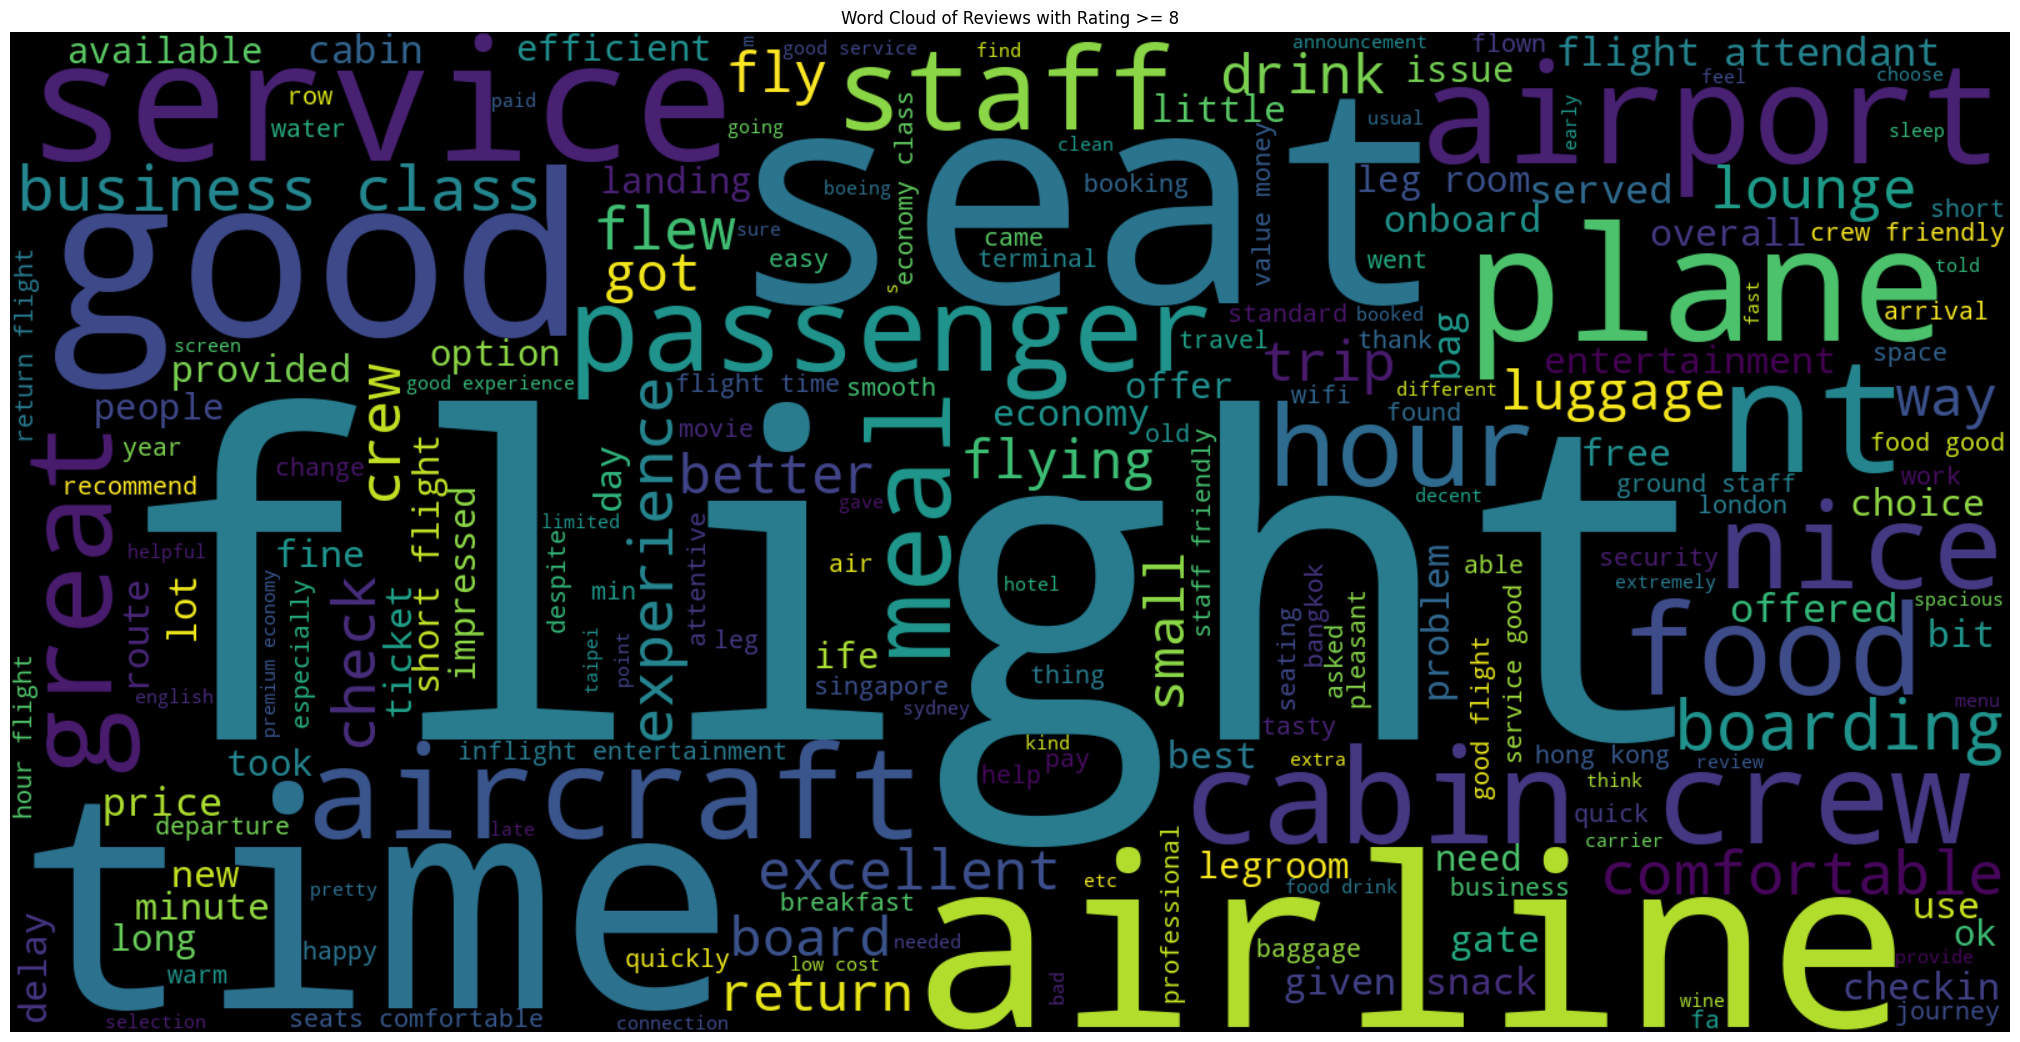

In [171]:
# (3.b)
# Creating word cloud of reviews
from wordcloud import WordCloud
# Getting all words with review is less than equal to 3
all_words_leq_3 = " ".join(
    data_df["Review_doc_tokens"][data_df["Overall_Rating"] < 3])
wordcloud = WordCloud(width=1600, height=800).generate(all_words_leq_3)
fig3 = plt.figure(figsize=(20, 10))
ax3 = fig3.add_axes([0, 0, 1, 1])
ax3.set_axis_off()
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Reviews with Rating <= 3")
#Getting all words with review is greater than equal to 8
all_words_geq_8 = " ".join(
    data_df["Review_doc_tokens"][data_df["Overall_Rating"] >= 8])
wordcloud = WordCloud(width=1600, height=800).generate(all_words_geq_8)
fig4 = plt.figure(figsize=(20, 10))
ax4 = fig4.add_axes([0, 0, 1, 1])
ax4.set_axis_off()
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of Reviews with Rating >= 8")

In [80]:
# (3.c)
# Correlate the 'Overall_rating' with the other features ('Seat Comfort',
# 'Cabin StaƯ Service', 'Food & Beverages', 'Ground Service',
# 'Inflight Entertainment', 'Wifi & Connectivity')

# Convert the columns to numeric, coercing errors to NaN
columns_to_be_analyzed = [
    "Seat Comfort", "Cabin Staff Service", "Food & Beverages",
    "Ground Service", "Inflight Entertainment", "Wifi & Connectivity"
]

for column in columns_to_be_analyzed:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Drop rows with NaN values in the specified column
data_df_dropped_rows = data_df.copy().dropna(subset=columns_to_be_analyzed)

# Compute the correlation matrix
correlation_matrix = data_df_dropped_rows[["Overall_Rating"] +
                             columns_to_be_analyzed].corr()


Text(0.5, 1.0, 'Correlation Matrix')

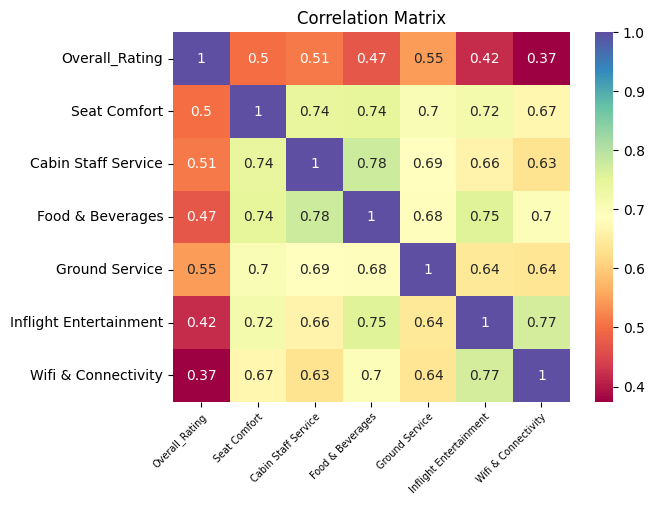

In [81]:
# Plot the correlation matrix
plt.figure()
ax = sns.heatmap(correlation_matrix, annot=True, cmap="Spectral")
plt.setp(ax.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor",
         fontsize=7)
plt.title("Correlation Matrix")

We can also see that *Ground Serivice* has the highest impact on the *Overall Rating* of the airlines. This is a very important insight, as it shows that the airlines should focus on improving the ground service to improve the overall rating of the airline. No features has a negative impact on the *Overall Rating* of the airlines.

In [82]:
# (4) Model I
# Classificate the reviews by (Negative < 4, Neutral >= 4 and <= 7, Positive > 7)
# based on the overall rating and some features ('Seat Comfort', 'Cabin StaƯ Service', 'Food & Beverages',
# 'Ground Service', 'Inflight Entertainment', 'Wifi & Connectivity')


data_df_dropped_rows["Sentiment"] = data_df_dropped_rows["Overall_Rating"].apply(lambda x: "Negative" if x < 4 else "Neutral" if x >= 4 and x <= 7 else "Positive")

# Spliting the data into training and test sets
from sklearn.model_selection import train_test_split

X_features = data_df_dropped_rows[columns_to_be_analyzed]
Y = data_df_dropped_rows["Sentiment"]

X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.3)

# Train a KNN classifier
from sklearn.neighbors import KNeighborsClassifier

knn_features = KNeighborsClassifier(n_neighbors=3)
knn_features.fit(X_train, Y_train)

# Evaluate the classifier
from sklearn.metrics import classification_report

Y_pred = knn_features.predict(X_test)
print("KNN classifier results")
print(classification_report(Y_test, Y_pred))

# Train a Neural Network classifier
from sklearn.neural_network import MLPClassifier

mlp_features = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
mlp_features.fit(X_train, Y_train)

# Evaluate the classifier
Y_pred = mlp_features.predict(X_test)
print("MLP classifier results")
print(classification_report(Y_test, Y_pred))




KNN classifier results
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.91      1167
     Neutral       0.37      0.30      0.33       137
    Positive       0.56      0.49      0.52       127

    accuracy                           0.83      1431
   macro avg       0.61      0.57      0.59      1431
weighted avg       0.82      0.83      0.82      1431

MLP classifier results
              precision    recall  f1-score   support

    Negative       0.90      0.94      0.92      1167
     Neutral       0.42      0.31      0.36       137
    Positive       0.55      0.49      0.52       127

    accuracy                           0.84      1431
   macro avg       0.62      0.58      0.60      1431
weighted avg       0.82      0.84      0.83      1431



In [83]:
# Cross validation score for model I classifiers
from sklearn.model_selection import cross_val_score

mlp_cross_features = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
scores = cross_val_score(mlp_cross_features, X_features, Y, cv=5)
print("MLP: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

knn_cross_features = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn_cross_features, X_features, Y, cv=5)
print("KNN: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


MLP: 0.84 accuracy with a standard deviation of 0.01
KNN: 0.83 accuracy with a standard deviation of 0.00


In [84]:
# Using the review text and title using the already tokenized data (Review_Title_doc and Review_doc)

# Current the values of collumn Review_doc_vec and Review_Title_doc_vec is a ndarray
# We need to "Flatten" the ndarray to a list of values to be used as features
# The operation that i'm doing is convert a dataframe from:
#  |    A   |    B   |   C
# 0| [1, 2] | [2, 3] | [2, 3]
# 1| [2, 3] | [3, 2] | [3, 3]
# To:
#  | A0  | A1  | B0  | B1  | C0  |  C1
# 0|  1  |  2  |  2  |  3  |  2  |  3
# 1|  2  |  3  |  3  |  2  |  3  |  3

data_df["Review_doc_vec"] = data_df["Review_doc"].apply(lambda x: x.vector)
data_df["Review_Title_doc_vec"] = data_df["Review_Title_doc"].apply(lambda x: x.vector)
edf = pd.concat([data_df[col].apply(pd.Series).add_prefix(col) for col in ["Review_doc_vec", "Review_Title_doc_vec"]], axis=1)


In [85]:
X_vec = edf
data_df["Sentiment"] = data_df["Overall_Rating"].apply(lambda x: "Negative" if x < 4 else "Neutral" if x >= 4 and x <= 7 else "Positive")
Y = data_df["Sentiment"]

# Spliting the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_vec, Y, test_size=0.3)

In [86]:

# (4) Model II
from sklearn.neighbors import KNeighborsClassifier
knn_vector_words = KNeighborsClassifier(n_neighbors=3)
knn_vector_words.fit(X_train, Y_train)

Y_pred = knn_vector_words.predict(X_test)
print("KNN with vectorized words")
print(classification_report(Y_test, Y_pred))

from sklearn.neural_network import MLPClassifier
mlp_vector_words = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
mlp_vector_words.fit(X_train, Y_train)

Y_pred = mlp_vector_words.predict(X_test)
print("MLP with vectorized words")
print(classification_report(Y_test, Y_pred))


KNN with vectorized words
              precision    recall  f1-score   support

    Negative       0.78      0.90      0.83      3681
     Neutral       0.35      0.18      0.23       771
    Positive       0.38      0.30      0.34       759

    accuracy                           0.70      5211
   macro avg       0.51      0.46      0.47      5211
weighted avg       0.66      0.70      0.67      5211

MLP with vectorized words
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      3681
     Neutral       0.38      0.35      0.36       771
    Positive       0.45      0.46      0.45       759

    accuracy                           0.72      5211
   macro avg       0.56      0.55      0.56      5211
weighted avg       0.72      0.72      0.72      5211



In [87]:
# Cross validation score for model II classifiers
from sklearn.model_selection import cross_val_score

mlp_cross_vector = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000)
scores = cross_val_score(mlp_cross_vector, X_vec, Y, cv=5)
print("MLP: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

knn_cross_vector = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn_cross_vector, X_vec, Y, cv=5)
print("KNN: %0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

MLP: 0.72 accuracy with a standard deviation of 0.01
KNN: 0.70 accuracy with a standard deviation of 0.00


The MLP classification model has the highest accuracy when using the features in the dataset. And a accuracy of 0.72 when using the vectorized reviews and reviews titles.

Text(0.5, 1.0, 'Boxplot of Ratings by Airlines')

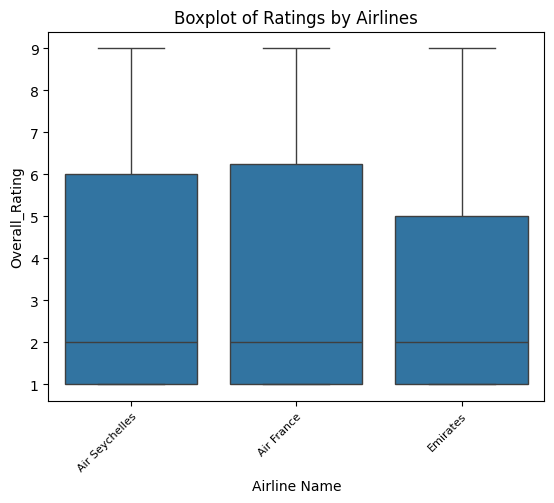

In [88]:
# "Emirates", "Air Seychelles", "Air France"
# The reviews will be analyzed by the sentiment and the overall rating

airlines_to_analyze = ["Emirates", "Air Seychelles", "Air France"]
airlines_df = data_df[data_df["Airline Name"].isin(airlines_to_analyze)]
plt.figure()
ax = sns.boxplot(x="Airline Name", y="Overall_Rating", data=airlines_df)
plt.setp(ax.get_xticklabels(),
         rotation=45,
         ha="right",
         rotation_mode="anchor",
         fontsize=8)
plt.title("Boxplot of Ratings by Airlines")

In [100]:
# Compare the similarity of the reviews
messages = data_df["Review_doc_tokens"].to_list()

doc_to_compare_with = nlp("delay")
delay_flights = []

# Marking in the dataframe the reviews that is similar to the doc_to_compare_with
for message in messages:
    doc = nlp(message)
    similarity = doc.similarity(doc_to_compare_with)
    delay_flights.append(similarity > 0.5)

data_df["Delay_Flight"] = delay_flights

Calculate NPS that is defined by the formula:

$ \% \text{NPS} = \% \text{Positive} - \% \text{Negative} \ $

Where:

$ \% \text{Positive} = \left( \frac{\text{Number of Positive Reviews}}{\text{Total Number of Reviews}} \right)$
$ \% \text{Negative} = \left( \frac{\text{Number of Negative Reviews}}{\text{Total Number of Reviews}} \right)$

In [102]:
# Calculating the NPS of the 3 airlines in airlines_to_analyze
nps = []
for airline in airlines_to_analyze:
    airline_df = data_df[data_df["Airline Name"] == airline]
    positive_reviews = airline_df["Sentiment"].value_counts().get("Positive", 0)
    negative_reviews = airline_df["Sentiment"].value_counts().get("Negative", 0)
    nps.append((positive_reviews - negative_reviews) / len(airline_df))

# Calculate NPS removing the rows where Delay_Flight is True
nps_without_delay = []
for airline in airlines_to_analyze:
    airline_df = data_df[(data_df["Airline Name"] == airline) & (data_df["Delay_Flight"] == False)]
    positive_reviews = airline_df["Sentiment"].value_counts().get("Positive", 0)
    negative_reviews = airline_df["Sentiment"].value_counts().get("Negative", 0)
    nps_without_delay.append((positive_reviews - negative_reviews) / len(airline_df))





[-0.5, -0.45454545454545453, -0.46]
[-0.47368421052631576, -0.4375, -0.41304347826086957]


In general the NPS is negative, showing that the public perception of the airlines is negative. And when removing the delay related reviews the NPS improves, showing the delays has a high impact on the public perception of the airlines.